In [1]:
#pip install Clustimage
#pip install tensorflow
#pip install keras

In [ ]:
#Link al dataset = https://www.muratkoklu.com/datasets/vtdhnd09.php
#Si se pullea hay que bajar las imagenes y crear una carpeta Img con los 5 tipos separados

In [2]:
from clustimage import Clustimage
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np
from PIL import Image
from matplotlib import cm
from collections import OrderedDict
import pickle
from umap import UMAP

n_eva = 5000

In [3]:
#Defino funciones:

#Funcion para leer los archivos, lee ".png" por defecto
def leer_img(img_path,formato=".png"):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path

#Funcion para verificar que los archivos sean todos del mismo tamaño (tamaño por defecto 128,128,3)
def ver_tam(ubicacion, size=(128,128,3),max=255):
  '''Función para verificar el tamaño de los archivos
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  size(tupla, por defecto 128,128,3) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).shape != size]
  if diferentes == []:
    print("Los tamaños son: ", size)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).shape)
    return diferentes

def r_max_min(ubicacion, rango=[0,255]): #Revisar esto y sumar max y min para que sea univoco
  '''Función para verificar el el valor máximo de las matrices
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  max(int, por defecto 255) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).max() > max(rango) or cv2.imread(x).min() < min(rango) ]
  if diferentes == []:
    print("El valor máximo es menor o igual: ", rango)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).min(), cv2.imread(dife).max())
    return diferentes

def sum_sse(KM):
  '''Suma cuadrada usando la .inertia_ del modelo'''
  sse = 0  
  sse = (KM.inertia_)
  return sse


def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd



In [4]:
dir_path = "C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img"

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

In [6]:
def leer_nimg(img_path,formato=".png",n=100):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''  
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  largo = len(path)
  if n<largo:
      path = path[:n]
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path


completo = []
for ct,directorio in enumerate(os.listdir(dir_path)):           
    path = leer_nimg(dir_path+"\\"+directorio,".jpg",n_eva)
    completo += path



Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Arborio\Arborio (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Basmati\Basmati (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Ipsala\Ipsala (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Jasmine\Jasmine (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Karacadag\Karacadag (1).jpg


In [ ]:
#Verificamos el tamño de las imagenes
size = (250,250,3)
diferentes = ver_tam(completo,size)
#Verificamos el si los valores se encuentran en rango
#ranguera = [0,255]
#max_val = r_max_min(path,ranguera)

In [7]:
tipos = ["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

para_labels = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels += temp*n_eva


In [8]:
df_paths = pd.DataFrame(completo)

In [9]:
df_paths = df_paths.rename(columns={0:"ubica"}) 
df_paths["file"] = df_paths["ubica"].str.split('\\').str.get(-1)

In [10]:
df_paths["label"] = para_labels
df_combi = df_paths

In [11]:
tipos = ["0","1","2","3","4"]

para_labels_num = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels_num += temp*n_eva
    
df_combi["label_num"] = para_labels_num

df_combi["label_num"] = df_combi["label_num"].astype('int64')

df_combi

,ubica,file,label,label_num
0,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1).jpg,Arborio,0
1,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10).jpg,Arborio,0
2,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (100).jpg,Arborio,0
3,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1000).jpg,Arborio,0
4,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10000).jpg,Arborio,0
...,...,...,...,...
24995,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14494).jpg,Karacadag,4
24996,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14495).jpg,Karacadag,4
24997,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14496).jpg,Karacadag,4
24998,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14497).jpg,Karacadag,4


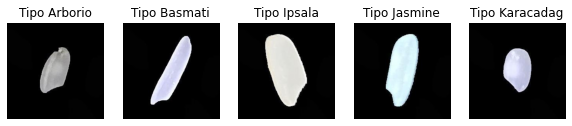

In [12]:
fig, axs = plt.subplots(1,5, figsize=(10, 10))
for ct,i in enumerate(df_combi["label"].unique()):
  testeo = df_combi[df_combi.label == i]
  ubica = testeo.sample().ubica.iloc[0]
  img = Image.open(ubica)
  axs[ct].imshow(img)
  axs[ct].set_title(f'Tipo {i}')
  axs[ct].axis('off')

In [13]:
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd

In [14]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [15]:
def preprocess(lista, model):
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress
    # lista de filenames
    filenmss = np.array(list(datays.keys()))

    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens
    print(featsss.shape)
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

def extract_features(file, model):
    # levanta imagen como array 224x224
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image')
    img = np.array(img)
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [16]:
import matplotlib.cm as cm

def grafica_silhouette(KM,d):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis for KMeans clustering on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

In [18]:
names, feat = preprocess(completo, model)

1/1 [==============================] - 0s 93ms/step
(5000, 1, 4096)


In [17]:
#Guardo en pickle el modelo
#pickle.dump(names, open('names-5k-img.pk1','wb'))
#pickle.dump(feat, open('feat-5k-img.pk1','wb'))

#Cargo el modelo
names = pickle.load(open('names-5k-img.pk1','rb'))
feat = pickle.load(open('feat-5k-img.pk1','rb'))


In [68]:
# get the unique labels

#label = df_combi['label'].tolist()
#unique_labels = list(set(label))
#unique_labels

['Karacadag', 'Arborio', 'Jasmine', 'Basmati', 'Ipsala']

In [99]:
import gower

In [18]:
#Valores con PCA 
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [100]:
#d_meta = gower.gower_matrix(x)


In [102]:
#Tarda mas de 23 minutos con 25k de imagenes, la matriz de gower tarda 5 minutos con la misma cantidad de img 
#import seaborn as sns
#sns.clustermap(d_meta)

In [19]:
#Para fijar los colores en los gráficos
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', plt.cm.tab10(np.arange(6)), 6)

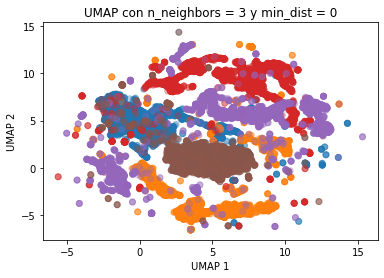

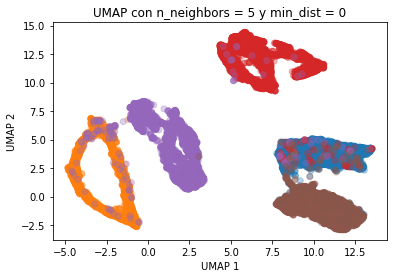

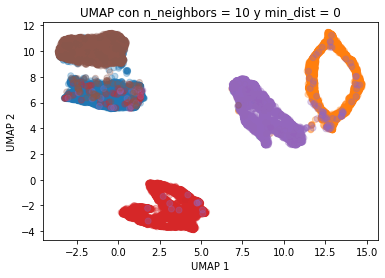

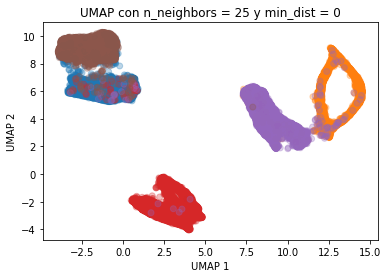

In [38]:
#Reduccion de dimensiones con UMAP
n_vecinos = [3,5,10,25]
for i in n_vecinos:
    um = UMAP(n_neighbors=i,min_dist=0)
    Xmap = um.fit_transform(feat)
    plt.scatter(Xmap[:,0],Xmap[:,1],c=df_combi.label_num,cmap=cmap,alpha=0.3)    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP con n_neighbors = {i} y min_dist = 0")
    plt.show()

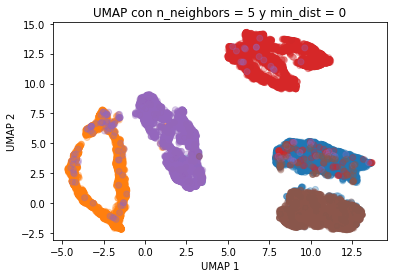

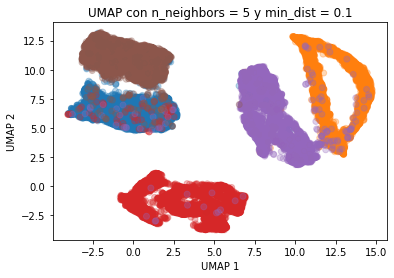

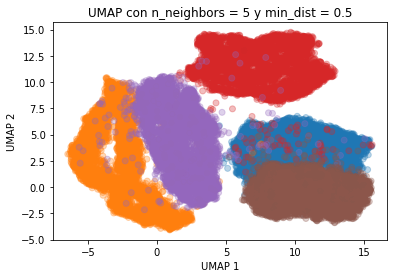

In [22]:
min_distan = [0,0.1,0.5]
for i in min_distan:
    um = UMAP(n_neighbors=5,min_dist=i)
    Xmap = um.fit_transform(feat)
    plt.scatter(Xmap[:,0],Xmap[:,1],c=df_combi.label_num,cmap=cmap,alpha=0.3)    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP con n_neighbors = 5 y min_dist = {i}")
    plt.show()

In [59]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


In [35]:
um = UMAP(n_neighbors=5,min_dist=0)
Xmap = um.fit_transform(feat)

In [36]:
kmeans_map = KMeans(n_clusters=5)
kmeans_map.fit(Xmap)

KMeans(n_clusters=5)

In [24]:
kmeans_pca =KMeans(n_clusters=5)
kmeans_pca.fit(x)

KMeans(n_clusters=5)

In [25]:
groups = {}
for file, cluster in zip(names,kmeans_map.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

Clipping cluster size from 5079 to 10
Clipping cluster size from 5011 to 10
Clipping cluster size from 4924 to 10
Clipping cluster size from 5103 to 10
Clipping cluster size from 4883 to 10


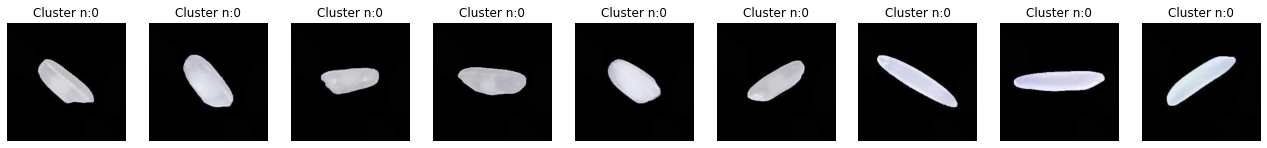

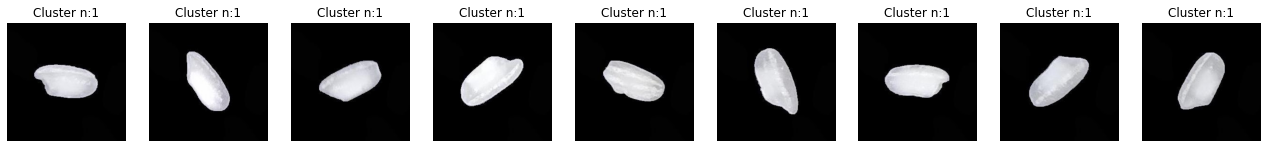

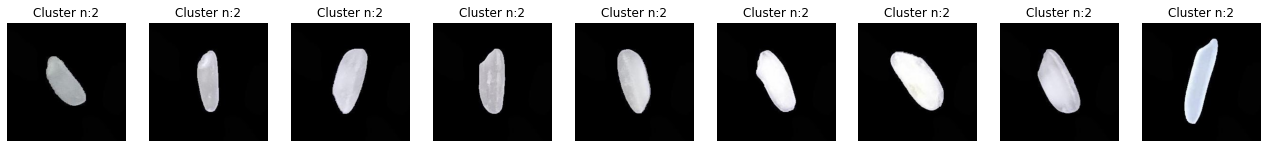

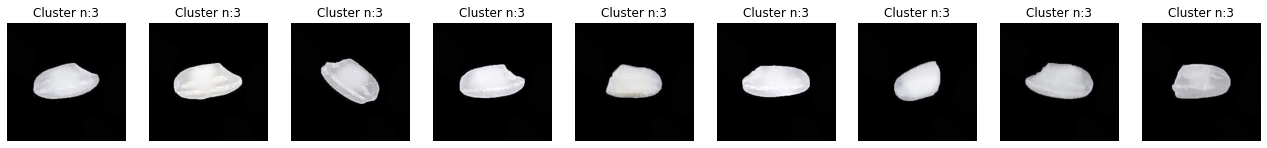

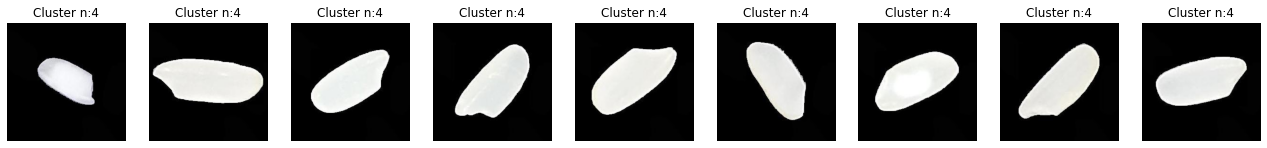

In [26]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

Text(0.5, 0.98, 'Kmeans básico')

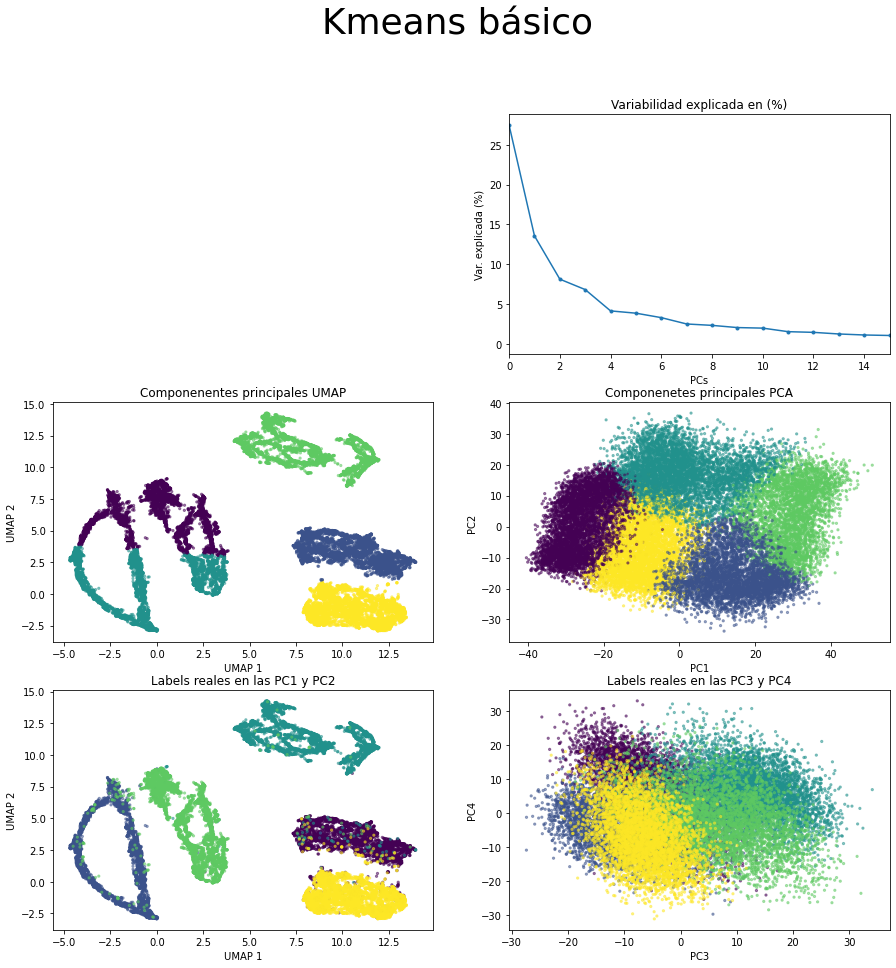

In [37]:
#Kmeans básico: 
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,1].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,1].set_xlim([0,15])
axs[0,1].set_xlabel('PCs')
axs[0,1].set_ylabel('Var. explicada (%)')
axs[0,1].set_title("Variabilidad explicada en (%)")
axs[0,0].axis('off')

axs[1,0].scatter(Xmap[:,0],Xmap[:,1],s=5,c=kmeans_map.labels_, alpha=0.5)
axs[1,0].set_xlabel('UMAP 1')
axs[1,0].set_ylabel('UMAP 2')
axs[1,0].set_title("Componenentes principales UMAP")
axs[1,1].scatter(x[:,0],x[:,1],s=5,c=kmeans_pca.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC1')
axs[1,1].set_ylabel('PC2')
axs[1,1].set_title("Componenetes principales PCA")
axs[2,0].scatter(Xmap[:,0],Xmap[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('UMAP 1')
axs[2,0].set_ylabel('UMAP 2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")

fig.suptitle("Kmeans básico", fontsize=36)

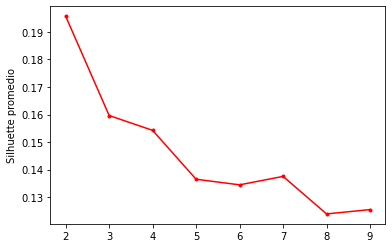

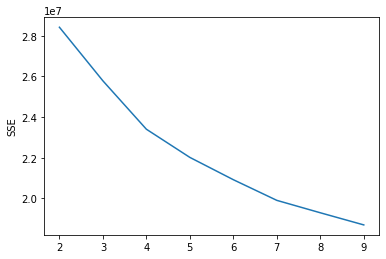

In [42]:
#Puntajes obtenidos 

from sklearn.metrics import silhouette_samples, silhouette_score


range_k = range(2,10)
silh = []
sse = []
for k in range_k:    
    model_calc = KMeans(n_clusters=k).fit(x)     
    silh.append(silhouette_score(x,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()


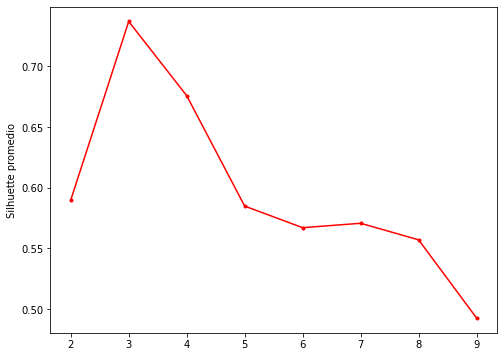

In [47]:
range_k = range(2,10)
silh = []
sse = []
for k in range_k:    
    model_calc = KMeans(n_clusters=k).fit(Xmap)     
    silh.append(silhouette_score(Xmap,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()



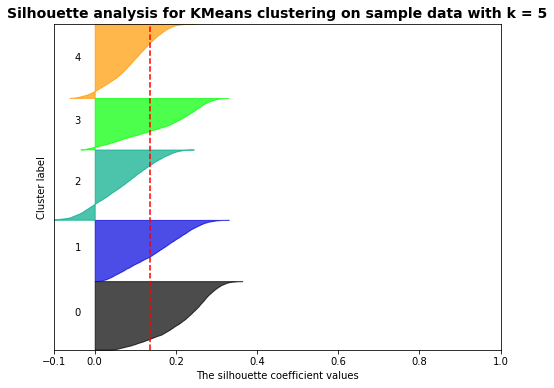

In [43]:
k = 5
grafica_silhouette(kmeans_pca,x)

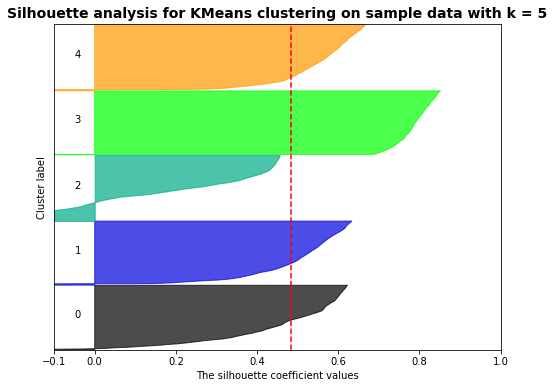

In [44]:
k = 5
grafica_silhouette(kmeans_map,Xmap)

In [45]:
from sklearn.metrics.cluster import adjusted_rand_score
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],kmeans_pca.labels_))
#vanDongen 
df_combi["predicted"] = kmeans_pca.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

Rand score ajustado:  0.4351635902060676
vanDongen:  0.8235619395328385


In [46]:
from sklearn.metrics.cluster import adjusted_rand_score
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],kmeans_map.labels_))
#vanDongen 
df_combi["predicted"] = kmeans_map.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

Rand score ajustado:  0.7371146944249083
vanDongen:  0.9099813805027265


In [78]:
# Segundo modelo Kmedoids
from sklearn_extra.cluster import KMedoids
KM_meta=KMedoids(n_clusters=5,init='k-medoids++').fit(x)

Text(0.5, 0.98, 'KMedoids 5 clusters')

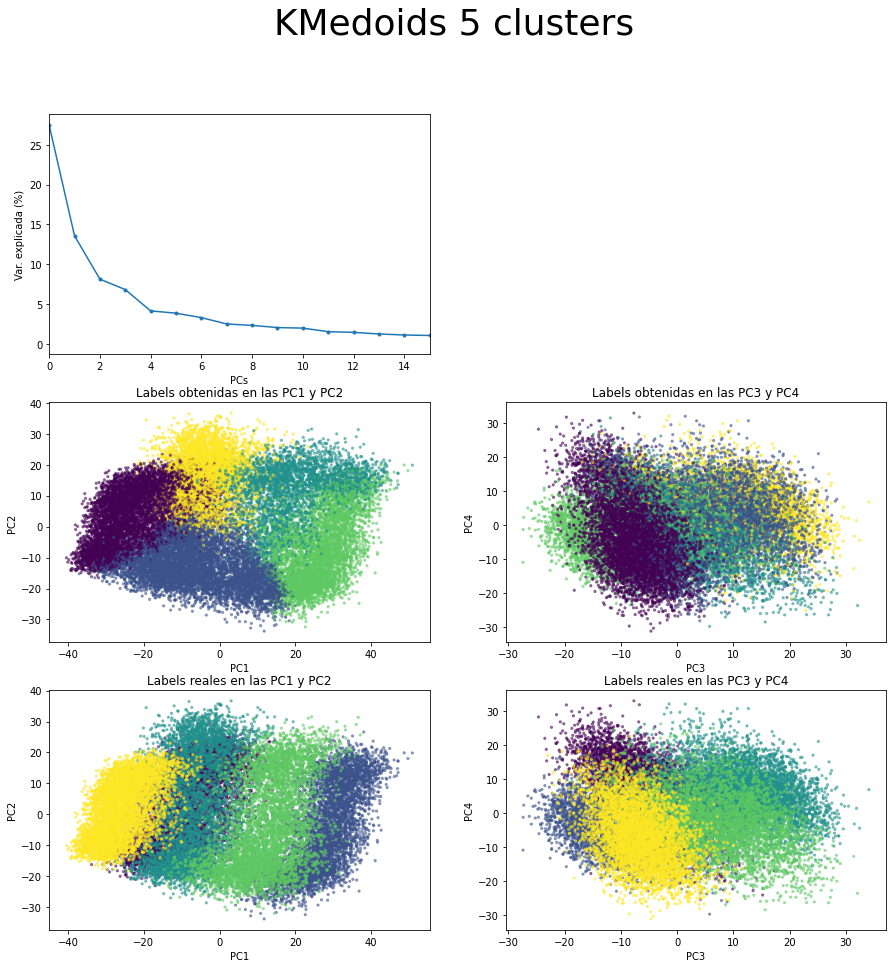

In [79]:
#KMedoids: 
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,1].axis('off')

axs[1,0].scatter(x[:,0],x[:,1],s=5,c=KM_meta.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,0].set_title("Labels obtenidas en las PC1 y PC2")
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=KM_meta.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[1,1].set_title("Labels obtenidas en las PC3 y PC4")
axs[2,0].scatter(x[:,0],x[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")

fig.suptitle("KMedoids 5 clusters", fontsize=36)



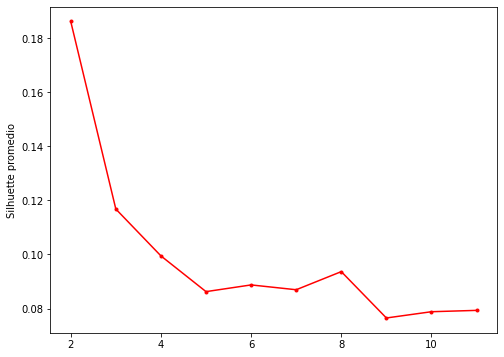

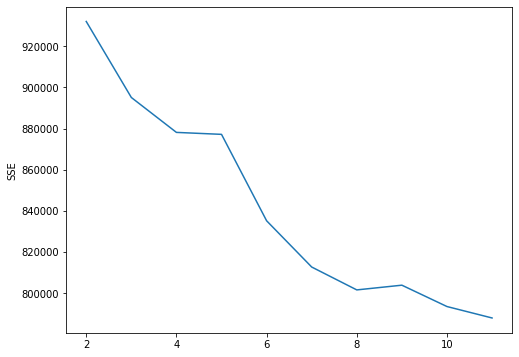

In [80]:
range_k = range(2,12)
silh = []
sse = []
for k in range_k:    
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    model_calc = KMedoids(n_clusters=k,init='heuristic').fit(x) 
    silh.append(silhouette_score(x,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()



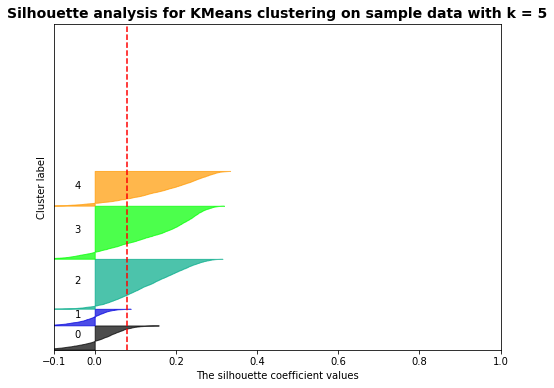

In [81]:
k = 5
grafica_silhouette(KM_meta,x)

In [82]:
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],KM_meta.labels_))
#vanDongen 
df_combi["predicted"] = KM_meta.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

Rand score ajustado:  0.2875862622289389
vanDongen:  0.9685272672656271


Text(0.5, 0.98, 'BisectingKMeans 5 clusters')

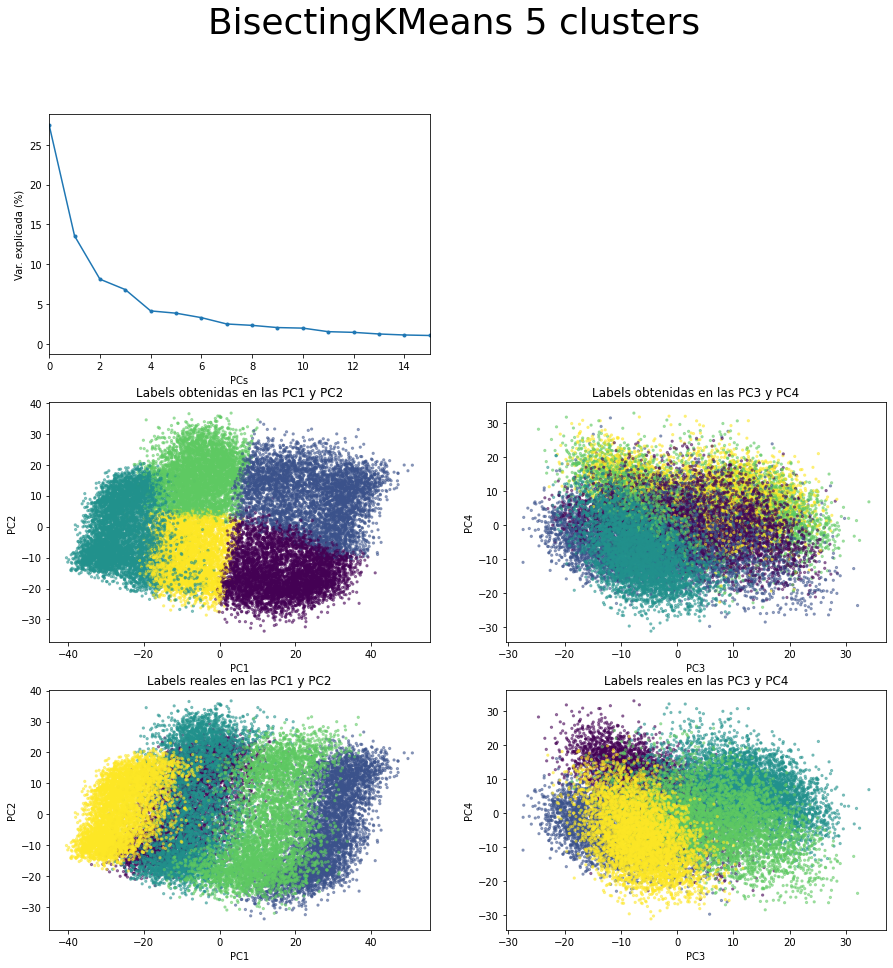

In [86]:
from sklearn.cluster import BisectingKMeans

biskmeans = BisectingKMeans(n_clusters=5).fit(x)

#AgglomerativeClustering: 
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,1].axis('off')

axs[1,0].scatter(x[:,0],x[:,1],s=5,c=biskmeans.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,0].set_title("Labels obtenidas en las PC1 y PC2")
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=biskmeans.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[1,1].set_title("Labels obtenidas en las PC3 y PC4")
axs[2,0].scatter(x[:,0],x[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")
fig.suptitle("BisectingKMeans 5 clusters", fontsize=36)

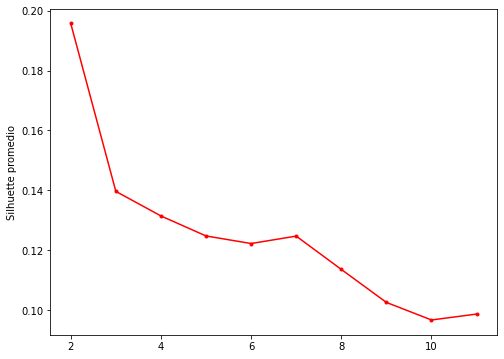

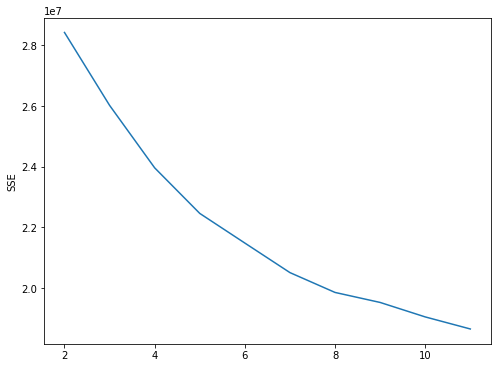

In [88]:
range_k = range(2,12)
silh = []
sse = []
for k in range_k:    
    model_calc = BisectingKMeans(n_clusters=k).fit(x) 
    silh.append(silhouette_score(x,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()




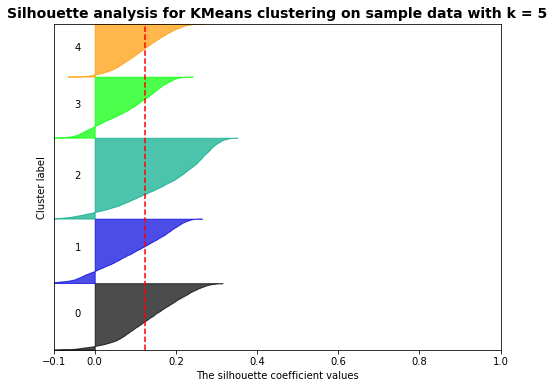

In [89]:
k = 5
grafica_silhouette(biskmeans,x)

In [90]:
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],biskmeans.labels_))
#vanDongen 
df_combi["predicted"] = biskmeans.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

Rand score ajustado:  0.37177171167337003
vanDongen:  0.8505335628227194


In [25]:
print(KM_meta.labels_)
print(KM_meta.medoid_indices_)
print(silhouette_score(x,KM_meta.labels_))
print(sum_sse(KM_meta))
silhouette_samples(x,KM_meta.labels_)

[4 3 2 ... 4 0 4]
[22145  7429 18252  4155 21085]
0.10054951
838639.2


array([0.12644018, 0.07433735, 0.05502946, ..., 0.12082005, 0.11161444,
       0.17942674], dtype=float32)

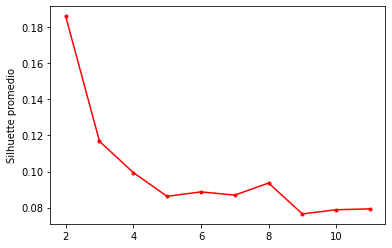

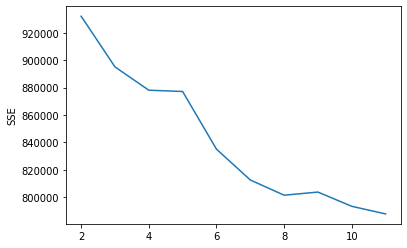

[932063.7, 895092.75, 878111.0, 877157.44, 835130.3, 812635.06, 801506.7, 803798.75, 793416.25, 787853.0]


In [26]:
range_k = range(2,12)
silh = []
sse = []
for k in range_k:    
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    KM_meta = KMedoids(n_clusters=k,init='heuristic').fit(x) 
    silh.append(silhouette_score(x,KM_meta.labels_))
    sse.append(sum_sse(KM_meta))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()



In [28]:
import matplotlib.cm as cm

def grafica_silhouette(KM,d):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis for KMeans clustering on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

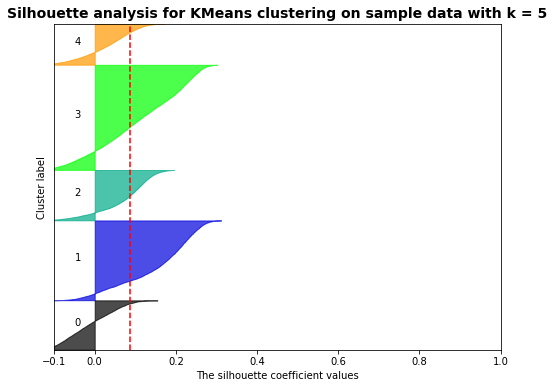

In [34]:
k = 5
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

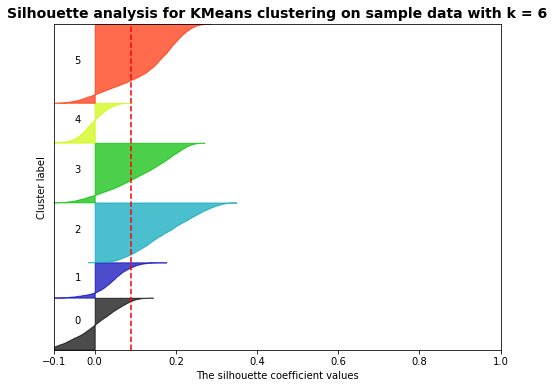

In [29]:
k = 6
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

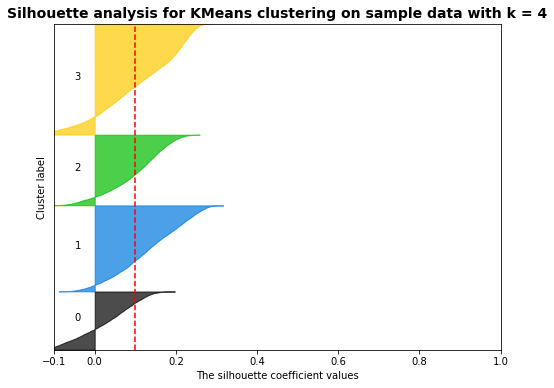

In [30]:
k = 4
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

In [32]:
df_combi["predicted"] = KM_meta.labels_

In [37]:
df_combi[["predicted","label_num"]]

,predicted,label_num
0,2,0
1,3,0
2,2,0
3,1,0
4,2,0
...,...,...
24995,1,4
24996,1,4
24997,1,4
24998,1,4


In [33]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(df_combi["label_num"],df_combi["predicted"])

0.3099885984320431

In [41]:
#función definida 
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

#vanDongen 
df_van = df_combi[["label_num","predicted"]]
vanDongen(df_van)

In [42]:
#vanDongen 
df_van = df_combi[["label_num","predicted"]]
vanDongen(df_van)

0.8475218736308235

In [114]:
pip install ipympl

     ------------------------------------- 511.6/511.6 kB 33.4 MB/s eta 0:00:00
  Obtaining dependency information for ipywidgets<9,>=7.6.0 from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for comm>=0.1.3 from https://files.pythonhosted.org/packages/fe/47/0133ac1b7dc476ed77710715e98077119b3d9bae56b13f6f9055e7da1c53/comm-0.1.4-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.9 from https://files.pythonhosted.org/packages/29/03/107d96077c4befed191f7ad1a12c7b52a8f9d2778a5836d59f9855c105f6/widgetsnbextension-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata
   ---------------------------------------- 139.4

In [115]:
import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski



In [110]:
df_combi["ubica"][0]

'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (1).jpg'

In [ ]:
def connected_components(filename, sigma=1.0, t=0.5, connectivity=2):
    # load the image
    image = iio.imread(filename)
    # convert the image to grayscale
    gray_image = ski.color.rgb2gray(image)
    # denoise the image with a Gaussian filter
    blurred_image = ski.filters.gaussian(gray_image, sigma=sigma)
    # mask the image according to threshold
    binary_mask = blurred_image < t
    # perform connected component analysis
    labeled_image, count = ski.measure.label(binary_mask,
                                                 connectivity=connectivity, return_num=True)
    return labeled_image, count

In [ ]:
imagen = iio.imread("C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (1).jpg")

(-0.5, 249.5, 249.5, -0.5)

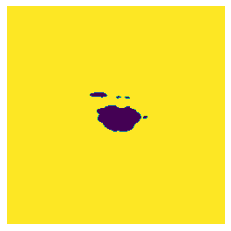

In [117]:
labeled_image, count = connected_components(filename="C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (1).jpg", sigma=2.0, t=0.9, connectivity=2)

fig, ax = plt.subplots()
plt.imshow(labeled_image)
plt.axis("off")